# IST664/CIS668 - Final Project
Originality Assertion:
I wrote all of the explanatory text and comments in this notebook. 

The root notebook was adapted from https://github.com/lukysummer/Machine-Translation-Seq2Seq-Keras


Name: ADITYA MANISHKUMAR SHAH


# Machine Translation: seq2seq model

In [2]:
%load_ext autoreload
%autoreload 1

In [17]:
import collections
import numpy as np
import tensorflow as tf
# Making relevant import statements for layers of the model.
from tensorflow.keras.layers import Input, Dense, Bidirectional, LSTM, Embedding
from tensorflow.keras.models import Model

# Model optimizer and loss parameters
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Suppressing warnings
import warnings
warnings.filterwarnings("ignore")

Verify access to the GPU

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2982305168147643588
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14465892352
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2364376005426287047
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


## Introduction

**Summary of the algorithm**

* An RNN stack acts as "encoder": it will process the input and return the internal states. In doing so, we discard the outputs of this RNN stack, only recovering the state. This state will act as our "context" of the decoder in the next step.
* Another RNN stack acts as "decoder": Trained to predict the next characters of our target, provided with previous characters of the same sequence. It is trained to convert the target sequences into the same sequences but offset by **one** timestep in the future, by using a process called **"teacher forcing"** used in training. Moreover, our encoder uses the intermediate states from the encoder as initial state, which is how the decoder infers about what it is supposed to generate.

# 1. Load Data
The dataset used in the example involves short French and English sentence pairs

Steps to load data include:
* Download data from the github raw
* Read the data into vectors.

In [5]:
!curl -O https://raw.githubusercontent.com/adityashah0112/Machine-Translation-Seq2Seq-Keras/master/data/small_vocab_en
!curl -O https://raw.githubusercontent.com/adityashah0112/Machine-Translation-Seq2Seq-Keras/master/data/small_vocab_fr

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 8872k  100 8872k    0     0  9968k      0 --:--:-- --:--:-- --:--:-- 9957k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9898k  100 9898k    0     0  10.7M      0 --:--:-- --:--:-- --:--:-- 10.7M


In [6]:
with open('./small_vocab_en', 'r') as f:
    eng_sentences = f.read().split('\n')
    
with open('./small_vocab_fr', 'r') as f:
    fre_sentences = f.read().split('\n')

print('Dataset Loaded')

Dataset Loaded


In [7]:
for sample_i in range(2):
    print('English Sentence {} :  {}'.format(sample_i+1, eng_sentences[sample_i]))
    print('French Sentence {}  :  {}\n'.format(sample_i+1, fre_sentences[sample_i]))

English Sentence 1 :  new jersey is sometimes quiet during autumn , and it is snowy in april .
French Sentence 1  :  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .

English Sentence 2 :  the united states is usually chilly during july , and it is usually freezing in november .
French Sentence 2  :  les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .



# 2. Pre-process text

The preprocessing will include steps such as:
* Tokenization from text to sequences
* Padding of these sequences with a start and end token that can be distinguehed from the other tokens in the text.


## 2.1. Tokenize function

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer

def tokenize(x, encode_start_end = False):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :param encode_start_end: if True, pad the start & end of sentence as separate tokens
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    # A start and end token is added to the sentence in a way that 
    # the start and end tokens are not similar to any other tokens occuring in the dataset.
    if encode_start_end:
        x = ["startofsentence " + sentence + " endofsentence" for sentence in x]
    tokenizer = Tokenizer()                         # Tokenizer instantiated
    tokenizer.fit_on_texts(x)                        # 
    tokenized_x = tokenizer.texts_to_sequences(x)
    
    return tokenized_x, tokenizer

## 2.2. Padding  function

In [9]:
from keras.preprocessing.sequence import pad_sequences

def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    if length is None:
        length = max([len(sentence) for sentence in x])
    
    # pad_sequences pads the input to the configurations mentioned such as length, 
    # position of padding, and removal(truncating) of characters if necessary.
    padded_x = pad_sequences(x, maxlen = length, padding = 'post', truncating = 'post')
    
    return padded_x

## 2.3. Executing both functions
Both these functions will come into play when we finally complete preprocessing of our data as shown

In [10]:
# Tokenization of english and french sentences, 
# where french has paddings of start and end tokens for RNN's performance.
eng_tokenized, eng_tokenizer = tokenize(eng_sentences)
fre_tokenized, fre_tokenizer = tokenize(fre_sentences, encode_start_end = True)

# Padding and expanding dimensions of the inputs and outputs.
eng_encoded = np.expand_dims(pad(eng_tokenized), axis=-1)
fre_encoded = np.expand_dims(pad(fre_tokenized), axis=-1)

# Recording the sizes of each vocabularies for further ease of usage.
eng_vocab_size = len(eng_tokenizer.word_index)
fre_vocab_size = len(fre_tokenizer.word_index)


In [19]:
# A sanity check and validation that evrything is as it is supposed to be...
print("English vocabulary size:\t", eng_vocab_size) # 199
print("French vocabulary size: \t", fre_vocab_size) # 346
print()

eng_seq_len = len(eng_encoded[0])
fre_seq_len = len(fre_encoded[0])
        
print("Length of longest English sentence:\t", eng_seq_len) # 15
print("Length of longest French sentence: \t", fre_seq_len) # 23
print()

print("Shape of English encoded tokens:\t", eng_encoded.shape)  # (137861, 15, 1)
print("Shape of French encoded tokens: \t", fre_encoded.shape)  # (137861, 23, 1)

English vocabulary size:	 199
French vocabulary size: 	 346

Length of longest English sentence:	 15
Length of longest French sentence: 	 23

Shape of English encoded tokens:	 (137861, 15, 1)
Shape of French encoded tokens: 	 (137861, 23, 1)


# 3. Build Seq2Seq Model & Train

The translation model we will now build is an encoder-decoder RNN.

It is made of:
* an encoder that reads a variable length input sequence and 
* a decoder that predicts a variable length output sequence.


## 3.1. Training model


### 3.1.1. Define Encoder

In [20]:
# Starting building the model using the LSTM unit for RNN's implementation.
english_input = eng_encoded   # (137861, 15,)
decoder_french_input = fre_encoded[:, :-1, :]
decoder_french_target = fre_encoded[:, 1:, :]
    

input_seq_encoder = Input(shape = (None, ),
                          name = "encoder_input")     # (batch_size, sentence_length, 1) 

embed_dim = 200
embedded_seq_encoder = Embedding(input_dim = eng_vocab_size, 
                                 output_dim = embed_dim)(input_seq_encoder)

encoder_lstm = LSTM(units = 256,             
                    activation = 'relu',
                    return_sequences = False,
                    return_state = True,
                    name = "encoder_LSTM")

_, last_hidden_encoder, last_cell_encoder = encoder_lstm(embedded_seq_encoder)


### 3.1.2. Define Decoder
The decoder input is defined as a sequence of French character one-hot encoded to binary vectors.

The decoder LSTM layer will return both, the sequences and state. 

The hidden and cell states are ignored and only the output sequence of hidden states is used. 

The final hidden and cell state from **the encoder** is used to initialize the state of the decoder.

In [21]:
input_seq_decoder = Input(shape = (None, 1),
                          name = "decoder_input")     # (batch_size, sentence_length, 1)

# Our decoder will return full output sequences, and to return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(units = 256,                          
                    activation = 'relu',
                    return_sequences = True,
                    return_state = True,
                    name = "decoder_LSTM")

all_hidden_decoder, _, _ = decoder_lstm(input_seq_decoder, 
                                        initial_state = [last_hidden_encoder, last_cell_encoder])

decoder_dense = Dense(fre_vocab_size,
                      activation = 'softmax',
                      name = "decoder_dense")
logits = decoder_dense(all_hidden_decoder)




### 3.1.3. Define final model with appropriate encoded input layers, and output layers.

In [22]:
final_rnn_model = Model(inputs = [input_seq_encoder, input_seq_decoder],
                        outputs = logits)

final_rnn_model.compile(loss = sparse_categorical_crossentropy,
                        optimizer = Adam(lr = 0.002),
                        metrics = ['accuracy'])



In [23]:
final_rnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 200)    39800       ['encoder_input[0][0]']          
                                                                                                  
 decoder_input (InputLayer)     [(None, None, 1)]    0           []                               
                                                                                                  
 encoder_LSTM (LSTM)            [(None, 256),        467968      ['embedding_1[0][0]']            
                                 (None, 256),                                                 

### 3.1.4. Train(Fit) the model

In [24]:
final_rnn_model.fit([english_input, decoder_french_input],
                    decoder_french_target,
                    batch_size = 1024,
                    epochs = 16,
                    validation_split = 0.2)

Epoch 1/16
108/108 [==============================] - 14s 86ms/step - loss: 1.5939 - accuracy: 0.6283 - val_loss: nan - val_accuracy: 0.7573
Epoch 2/16
108/108 [==============================] - 9s 84ms/step - loss: 0.6312 - accuracy: 0.7898 - val_loss: nan - val_accuracy: 0.8218
Epoch 3/16
108/108 [==============================] - 9s 85ms/step - loss: 0.4534 - accuracy: 0.8438 - val_loss: nan - val_accuracy: 0.8673
Epoch 4/16
108/108 [==============================] - 9s 85ms/step - loss: 0.6158 - accuracy: 0.8262 - val_loss: nan - val_accuracy: 0.6219
Epoch 5/16
108/108 [==============================] - 9s 86ms/step - loss: 0.6763 - accuracy: 0.8005 - val_loss: nan - val_accuracy: 0.8653
Epoch 6/16
108/108 [==============================] - 9s 84ms/step - loss: 0.3330 - accuracy: 0.8860 - val_loss: nan - val_accuracy: 0.9006
Epoch 7/16
108/108 [==============================] - 9s 85ms/step - loss: 0.2343 - accuracy: 0.9191 - val_loss: nan - val_accuracy: 0.9341
Epoch 8/16
108/108 

### 3.1.5. Visualize the model

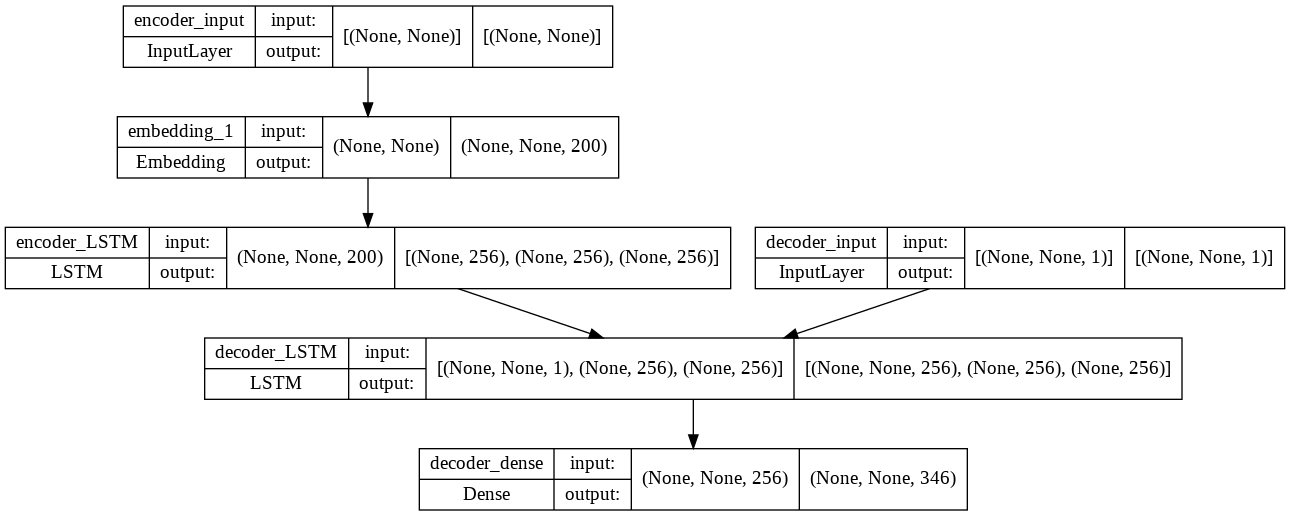

In [25]:
# This uses a Keras visualization tool to summarize the model and should
# confirm what you reviewed in the table above.
from IPython.display import Image
from keras.utils.vis_utils import plot_model
plot_model(final_rnn_model, show_shapes=True, show_layer_names=True)

# Image will be saved under the name 'model.png'
Image('model.png')

## 3.2. Inference model
New inference models are required for making predictions, these are:
* a model for encoding English input sequences of characters and 
* a model that takes the French character sequence generated and the encoding as input and predicts the next sequence character.


### 3.2.1. Encoder Model for inference
The encoder model takes the input layer from the encoder in the trained model and produces the hidden and cell states as shown below.

In [26]:
last_states_encoder = [last_hidden_encoder, last_cell_encoder]
inference_encoder_model = Model(inputs = input_seq_encoder, 
                                outputs = last_states_encoder)

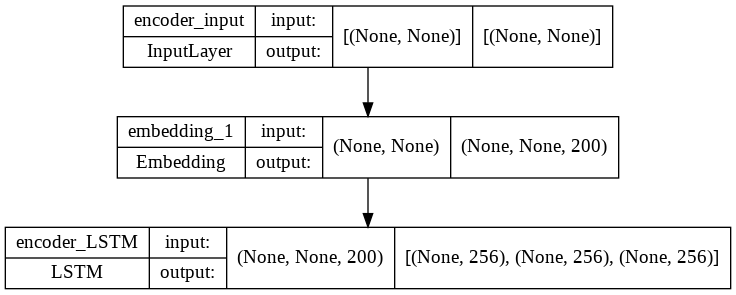

In [27]:
plot_model(inference_encoder_model, show_shapes=True, show_layer_names=True, to_file='encoder_model.png')
# Image will be saved under the name 'model.png'
Image('encoder_model.png')


### 3.2.2. Decoder Model for inference
The decoder needs hidden state and cell state from the trained encoder as the initial states of the new encoder model defined above. 

Because the decoder is separate, these states will be given as inputs to the model, and must be defined as inputs.

In [28]:
decoder_initial_state = [Input(shape = (256,)), Input(shape = (256,))]  
all_hidden_decoder, last_hidden_decoder, last_cell_decoder = decoder_lstm(input_seq_decoder, 
                                                                          initial_state = decoder_initial_state)
logits = decoder_dense(all_hidden_decoder)
inference_decoder_model = Model(inputs  = [input_seq_decoder] + decoder_initial_state, 
                                outputs = [logits, 
                                          last_hidden_decoder, 
                                          last_cell_decoder])

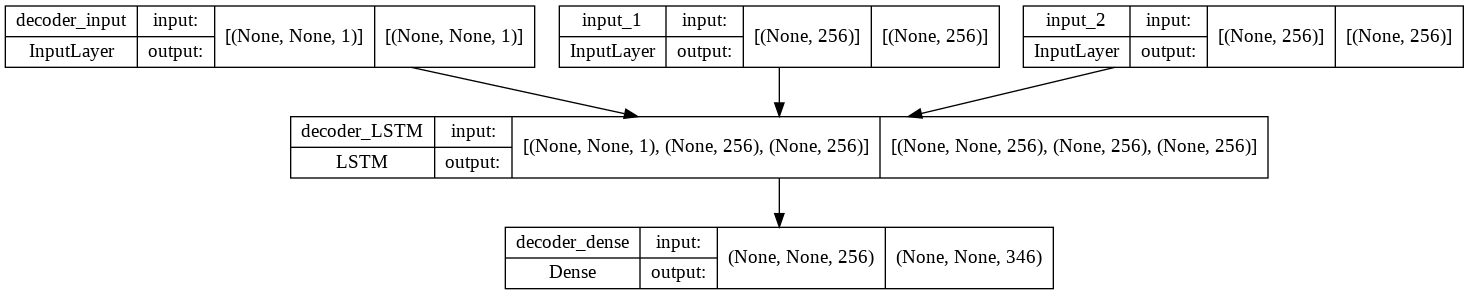

In [29]:
plot_model(inference_decoder_model, show_shapes=True, show_layer_names=True, to_file='decoder_model.png')
# Image will be saved under the name 'model.png'
Image('decoder_model.png')

### 3.2.3. Decode Sequence Function

Both the **encoder and decoder will be called recursively** for each character that is to be generated in the translated sequence.

On the first call, the **hidden and cell states from the encoder** will be used to **initialize the decoder LSTM layer**, provided as input to the model directly.

On subsequent **recursive calls to the decoder**, the last hidden and cell state must be provided to the model. These state values are already within the decoder; however, we need to **re-initialize the state on each call** in order to take the final states from the encoder on the first call.



In [30]:
target_id_to_word = {idx:word for word, idx in fre_tokenizer.word_index.items()}

def decode_sequence(input_seq):
    """
    Gets predictions using the final model defined above
    :param input_seq: (list) encoded english sentence (list of word ids)
    returns : translated French sentence
    """
    decoder_input = inference_encoder_model.predict(input_seq)

    # Initialize decoder input as a length 1 sentence containing "startofsentence",
    # --> feeding the start token as the first predicted word
    prev_word = np.zeros((1, 1, 1))
    prev_word[0, 0, 0] = fre_tokenizer.word_index["startofsentence"]

    stop_condition = False
    translation = []
    while not stop_condition:
        # 1. predict the next word using decoder model
        logits, last_h, last_c = inference_decoder_model.predict([prev_word] + decoder_input)
        
        # 2. Update prev_word with the predicted word
        predicted_id = np.argmax(logits[0, 0, :])
        predicted_word = target_id_to_word[predicted_id]
        translation.append(predicted_word)

        # 3. Enable End Condition: (1) if predicted word is "endofsentence" OR
        #                          (2) if translated sentence reached maximum sentence length
        if (predicted_word == 'endofsentence' or len(translation) > decoder_french_target.shape[1]):
            stop_condition = True

        # 4. Update prev_word with the predicted word
        prev_word[0, 0, 0] = predicted_id

        # 5. Update initial_states with the previously predicted word's encoder output
        decoder_input = [last_h, last_c]

    return " ".join(translation).replace('endofsentence', '')

## 3.3. Predictions

For making predictions, we use the `decode_sequence` method created above and call it over our **encoded english sequences**

The results obtained will be compared with the **corresponding french translations** in the downloaded file and the **machine-translated french sequences**.

In [31]:
# TODO: Print prediction(s)
for i in [293, 296, 393, 418]:
    english_seq = eng_encoded[i].reshape(1, eng_encoded.shape[1])
    french_translation = decode_sequence(english_seq)
    
    print("English Sentence            : ", eng_sentences[i])
    print("Predicted French Translation: ", french_translation)
    print("Correct French Translation  : ", fre_sentences[i])
    print()

English Sentence            :  i plan to visit france in spring .
Predicted French Translation:  je prévois de visiter la france au printemps 
Correct French Translation  :  je prévois de visiter la france au printemps .

English Sentence            :  she likes grapes , apples , and grapefruit.
Predicted French Translation:  elle aime les raisins les pommes et le pamplemousse 
Correct French Translation  :  elle aime les raisins , les pommes et le pamplemousse .

English Sentence            :  my most loved animal was that bird .
Predicted French Translation:  mon animal le plus aimé était cet oiseau 
Correct French Translation  :  mon animal le plus aimé était cet oiseau .

English Sentence            :  france is pleasant during july , but it is usually dry in december .
Predicted French Translation:  la france est agréable en juillet mais il est généralement sec en décembre 
Correct French Translation  :  la france est agréable en juillet , mais il est généralement sec en décembre 

# Conclusion

This tutorial lines out how to define an encoder-decoder sequence-to-sequence prediction model for translation, as described by the author of the Keras deep learning library.

The process included:
* The neural machine translation example provided with Keras and described on the Keras blog.
* How to correctly define an encoder-decoder LSTM for training a neural machine translation model.
* How to correctly define an inference model for using a trained encoder-decoder model to translate new sequences.

The results produced by the model seems like perfect translations for the standarad of the simple dataset with limited vocabulary!

# References

* https://nextjournal.com/gkoehler/machine-translation-seq2seq-cpu
* https://machinelearningmastery.com/define-encoder-decoder-sequence-sequence-model-neural-machine-translation-keras/
* https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

Adapted from github Repo:
https://github.com/lukysummer/Machine-Translation-Seq2Seq-Keras
